# <p style="text-align: center; font-style: strong;">Anonymization with Tensorflow Scala</p>
### <p style="text-align: center;">(Almond: 0.8.0, Scala: 2.12.8)</p>


## Dependencies

In [1]:
interp.load.ivy(coursierapi.Dependency.of("com.github.haifengl" % "smile-scala_2.12" % "1.5.3"))
interp.load.ivy(coursierapi.Dependency.of("org.platanios", "tensorflow_2.12", "0.4.1").withClassifier("darwin-cpu-x86_64"))

In [2]:
import org.tensorflow.framework.GraphDef
import org.platanios.tensorflow.api.core.{ Graph, NewAxis, Shape }
import org.platanios.tensorflow.api.ops.{ Files, Image => TImage }
import org.platanios.tensorflow.api.{ Tensor, UByte, tf, --- }
import org.platanios.tensorflow.api.core.client.{ FeedMap, Session }
import org.platanios.tensorflow.api.ops.NN._
import java.io.{ BufferedInputStream, File, FileInputStream }
import java.util.Arrays.fill
import scala.math.sqrt
import scala.math.abs
import smile.stat.distribution.GaussianDistribution

import org.tensorflow.framework.GraphDef

import org.platanios.tensorflow.api.core.{ Graph, NewAxis, Shape }

import org.platanios.tensorflow.api.ops.{ Files, Image => TImage }

import org.platanios.tensorflow.api.{ Tensor, UByte, tf, --- }

import org.platanios.tensorflow.api.core.client.{ FeedMap, Session }

import org.platanios.tensorflow.api.ops.NN._

import java.io.{ BufferedInputStream, File, FileInputStream }

import java.util.Arrays.fill

import scala.math.sqrt

import scala.math.abs

import smile.stat.distribution.GaussianDistribution

## Initialization
Just modify *modelsFileName* and *imageName* and after respect the following project structure :

```
data    
└───models
   │   X.pb  
└───images
   │   X.png
```


In [3]:
val modelFilename = "face.pb"
val imageFilename = "people.png"

val basedir = System.getProperty("user.dir")
val imageFilePath = s"${basedir}/data/images/${imageFilename}"
val modelGraphPath = s"${basedir}/data/models/${modelFilename}"

modelFilename: String = "face.pb"
imageFilename: String = "people.png"
basedir: String = "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/anonymization"
imageFilePath: String = "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/anonymization/data/images/people.png"
modelGraphPath: String = "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/anonymization/data/models/face.pb"

In [4]:
lazy val graph = Graph.fromGraphDef(GraphDef.parseFrom(new BufferedInputStream(new FileInputStream(new File(modelGraphPath)))))

graph: Graph = org.platanios.tensorflow.api.core.Graph@22b24d35

In [5]:
val session = Session(graph)
val sessionSimple = Session()

session: Session = org.platanios.tensorflow.api.core.client.Session@5ea96e71
sessionSimple: Session = org.platanios.tensorflow.api.core.client.Session@650980fd

## Prepare recuperation of graph results

In [6]:
val imagePlaceholder = graph.getOutputByName("image_tensor:0").toUByte
val detectionBoxes = graph.getOutputByName("detection_boxes:0").toFloat
val detectionScores = graph.getOutputByName("detection_scores:0").toFloat
val detectionClasses = graph.getOutputByName("detection_classes:0").toFloat
val numDetections = graph.getOutputByName("num_detections:0").toFloat

imagePlaceholder: org.platanios.tensorflow.api.ops.Output[UByte] = Output(
  image_tensor,
  0
)
detectionBoxes: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  detection_boxes,
  0
)
detectionScores: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  detection_scores,
  0
)
detectionClasses: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  detection_classes,
  0
)
numDetections: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  num_detections,
  0
)

## Open and transform image

In [7]:
def transformImages(imagefilePath: String, numChannel: Int, s: Session = Session()): Tensor[UByte] = {
    val tensorImageOuts = TImage.decodePng(Files.readFile(imageFilePath), numChannel)
    s.run(fetches = tensorImageOuts)
}

defined function transformImages

In [8]:
val imageOuts = transformImages(imageFilePath, 3)

imageOuts: Tensor[UByte] = Tensor[UByte, [633, 633, 3]]

In [9]:
val feeds = FeedMap(Map(imagePlaceholder -> imageOuts.slice(NewAxis, ---)))

feeds: FeedMap = org.platanios.tensorflow.api.core.client.FeedMap@32b35cb7

## Detection of face 
*boxes* = Positions of face detected

*score* = Confidence for each detection

*classes* = Face or plate

*num* = Number of detection

In [10]:
val Seq(boxes, scores, classes, num) =
      session.run(
        fetches =
          Seq(detectionBoxes, detectionScores, detectionClasses, numDetections),
        feeds = feeds)

boxes: Tensor[Float] = Tensor[Float, [1, 100, 4]]
scores: Tensor[Float] = Tensor[Float, [1, 100]]
classes: Tensor[Float] = Tensor[Float, [1, 100]]
num: Tensor[Float] = Tensor[Float, [1]]

In [11]:
val height = imageOuts.shape(0)
val width = imageOuts.shape(1)
val thereshold = 0.7

height: Int = 633
width: Int = 633
thereshold: Double = 0.7

## Filter detections to keep only one above our thereshold

In [12]:
val tabBoxesFiltered = for {
    i <- 0 until num(0).scalar.toInt
    val box = boxes(0, i).entriesIterator.toSeq
    y1 = (box(0) * height).toInt
    x1 = (box(1) * width).toInt
    y2 = (box(2) * height).toInt
    x2 = (box(3) * width).toInt
    val labelBox = (y1, x1, y2, x2)
    val labelId = classes(0, i).scalar.toInt
    val score = scores(0, i).scalar
    if (score > thereshold)
  } yield (labelId, score, labelBox)


tabBoxesFiltered: collection.immutable.IndexedSeq[(Int, Float, (Int, Int, Int, Int))] = Vector(
  (1, 0.9918419F, (100, 527, 197, 594)),
  (1, 0.9904974F, (215, 430, 325, 510)),
  (1, 0.9815732F, (105, 96, 190, 166)),
  (1, 0.96975404F, (223, 61, 326, 140))
)

## Create a mask to delimitate areas where the blurring need to be apply in the image


In [13]:
// 0 is corresponding to an area where no blur is necessary and 1 is the opposite
val maskBlur = Array.fill(height, width)(0)

maskBlur: Array[Array[Int]] = Array(
  Array(
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
...

In [14]:
// Thanks to the box detection, we fill our mask with 1 where we need to apply blurring
tabBoxesFiltered.foreach { case (_, _, (x1,y1,x2,y2)) => (x1 until x2).foreach(xi => fill(maskBlur(xi), y1, y2, 1)) }
val maskBlurFlatten = maskBlur.flatten

maskBlurFlatten: Array[Int] = Array(
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
...

In [15]:
val tensorMaskFlatten = Tensor(maskBlurFlatten)
val tensorMaskReshape = tf.reshape(tensorMaskFlatten, Shape(height, width))

tensorMaskFlatten: Tensor[Int] = Tensor[Int, [1, 400689]]
tensorMaskReshape: org.platanios.tensorflow.api.ops.Output[Int] = Output(
  Reshape,
  0
)

## Params for blurring and smoothing

In [16]:
val channels = 3 // RVB = 3
val smooth_boxes = true // Smooth area around blurring
val kernel_size = 31 // Kernel for blurring
val sigma = 2 // Standard deviation for blurring
val box_kernel_size = 9 // Size for smoothing, need to be > 1

channels: Int = 3
smooth_boxes: Boolean = true
kernel_size: Int = 31
sigma: Int = 2
box_kernel_size: Int = 9

## Generate a 2D gaussian filter...

In [17]:
val gaussian = new GaussianDistribution(0, sigma)
val normalDistribution = new GaussianDistribution(0, 1)

gaussian: GaussianDistribution = Gaussian Distribution(0.0000, 2.0000)
normalDistribution: GaussianDistribution = Gaussian Distribution(0.0000, 1.0000)

In [18]:
val interval = (2 * sigma + 1.0) / kernel_size

interval: Double = 0.16129032258064516

In [19]:
val start = (-sigma - interval/2.0)
val step = ((2.0*sigma + interval) / kernel_size)

val g1dcdf = (0 to kernel_size).map(i => normalDistribution.cdf(start + i*step))

start: Double = -2.0806451612903225
step: Double = 0.13423517169614985
g1dcdf: collection.immutable.IndexedSeq[Double] = Vector(
  0.01873319848942179,
  0.025802755290431842,
  0.03497959438708308,
  0.046679440909077774,
  0.06132997092267093,
  0.07934822211081953,
  0.10111319200153904,
  0.12693517801231424,
  0.15702415021202284,
  0.1914600320224646,
  0.23016807467471875,
  0.2729024502537966,
  0.31924070423478784,
  0.3685908138608145,
  0.4202113763203325,
  0.4732440469903773,
  0.5267559530096226,
  0.5797886236796677,
  0.6314091861391855,
  0.6807592957652122,
  0.7270975497462034,
  0.7698319253252813,
  0.8085399679775355,
  0.8429758497879771,
  0.8730648219876858,
  0.8988868079984611,
  0.9206517778891805,
  0.9386700290773291,
  0.9533205590909223,
  0.965020405612917,
  0.9741972447095681,
  0.9812668015105782
)

In [20]:
val k1d = g1dcdf.sliding(2).map { case Seq(x, y) => y - x }.toVector

k1d: Vector[Double] = Vector(
  0.007069556801010051,
  0.009176839096651235,
  0.011699846521994697,
  0.014650530013593156,
  0.0180182511881486,
  0.021764969890719507,
  0.025821986010775205,
  0.030088972199708602,
  0.03443588181044174,
  0.038708042652254165,
  0.04273437557907786,
  0.04633825398099123,
  0.04935010962602665,
  0.051620562459518016,
  0.0530326706700448,
  0.053511906019245326,
  0.05303267067004502,
  0.05162056245951785,
  0.049350109626026706,
  0.04633825398099123,
  0.04273437557907789,
  0.03870804265225414,
  0.03443588181044166,
  0.03008897219970863,
  0.025821986010775344,
  0.02176496989071941,
  0.018018251188148593,
  0.014650530013593177,
  0.011699846521994739,
  0.009176839096651124,
  0.0070695568010100684
)

In [21]:
val k1dSqrt = for {
    x <- k1d
    y <- k1d
} yield sqrt(x*y)

k1dSqrt: Vector[Double] = Vector(
  0.007069556801010051,
  0.00805457542316823,
  0.009094653899425827,
  0.01017707001528433,
  0.011286321377201846,
  0.012404381923929748,
  0.013511106424644218,
  0.014584776242707747,
  0.015602769704503965,
  0.016542330736206146,
  0.01738140085010376,
  0.018099472881226337,
  0.01867842078809845,
  0.019103258842607187,
  0.019362785894884587,
  0.019450076070117735,
  0.01936278589488463,
  0.01910325884260716,
  0.01867842078809846,
  0.018099472881226337,
  0.017381400850103767,
  0.01654233073620614,
  0.015602769704503945,
  0.014584776242707754,
  0.013511106424644254,
  0.01240438192392972,
  0.011286321377201843,
  0.010177070015284336,
  0.009094653899425844,
  0.00805457542316818,
  0.00706955680101006,
  0.00805457542316823,
  0.009176839096651235,
  0.01036183424823327,
  0.011595066046185508,
  0.012858872110596817,
  0.014132714765061656,
  0.015393641894524608,
...

In [22]:
val sumK1d = k1dSqrt.sum
val kernel = k1dSqrt.map(_ / sumK1d)

sumK1d: Double = 27.554057871338596
kernel: Vector[Double] = Vector(
  2.565704417846825E-4,
  2.9231902831802146E-4,
  3.300658633255604E-4,
  3.6934922844414857E-4,
  4.0960650623230864E-4,
  4.501834895553674E-4,
  4.90349061751021E-4,
  5.293150036488331E-4,
  5.662603227938264E-4,
  6.003591490389255E-4,
  6.308109292382552E-4,
  6.568714113086477E-4,
  6.778827596035326E-4,
  6.933011076556594E-4,
  7.027199400283443E-4,
  7.058879008289183E-4,
  7.027199400283458E-4,
  6.933011076556583E-4,
  6.77882759603533E-4,
  6.568714113086477E-4,
  6.308109292382554E-4,
  6.003591490389253E-4,
  5.662603227938256E-4,
  5.293150036488333E-4,
  4.903490617510224E-4,
  4.501834895553664E-4,
  4.0960650623230854E-4,
  3.6934922844414884E-4,
  3.3006586332556104E-4,
  2.923190283180197E-4,
  2.565704417846828E-4,
  2.9231902831802146E-4,
  3.3304855275770014E-4,
  3.760547465138166E-4,
  4.208115588755643E-4,
  4.666779815386997E-4,
  5.129086550900489E-4,
  5.586705945964094E-4,
...

In [23]:
val kernelBlurring = tf.reshape(kernel, Shape(kernel_size, kernel_size, 1, 1)).toFloat

kernelBlurring: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Reshape_1_0/CastToFloat/Cast,
  0
)

## Generate smoothing filter

In [24]:
val filter_size = box_kernel_size
val factor: Int = (((filter_size + 1) / 2).toInt)
val center = if (filter_size % 2 == 1) factor - 1 else factor - 0.5

val kernelTemp = for {
    i <- 0 until filter_size
    j <- 0 until filter_size
} yield (1.0f - abs(i - center).toFloat / factor.toFloat) * (1.0f - abs(j - center).toFloat / factor.toFloat)
val kernelFlat = kernelTemp
val sumSmoothing = kernelFlat.sum
val kernelSmoothing = Tensor(kernelFlat.map(element => element / sumSmoothing))
val tensorSmoothing = tf.reshape(kernelSmoothing, Shape(filter_size, filter_size, 1, 1))

filter_size: Int = 9
factor: Int = 5
center: Double = 4.0
kernelTemp: collection.immutable.IndexedSeq[Float] = Vector(
  0.039999995F,
  0.07999999F,
  0.12F,
  0.16F,
  0.19999999F,
  0.16F,
  0.12F,
  0.07999999F,
  0.039999995F,
  0.07999999F,
  0.15999998F,
  0.24F,
  0.32F,
  0.39999998F,
  0.32F,
  0.24F,
  0.15999998F,
  0.07999999F,
  0.12F,
  0.24F,
  0.36F,
  0.48000002F,
  0.6F,
  0.48000002F,
  0.36F,
  0.24F,
  0.12F,
  0.16F,
  0.32F,
  0.48000002F,
  0.64000005F,
  0.8F,
  0.64000005F,
  0.48000002F,
  0.32F,
  0.16F,
  0.19999999F,
  0.39999998F,
...
kernelFlat: collection.immutable.IndexedSeq[Float] = Vector(
  0.039999995F,
  0.07999999F,
  0.12F,
  0.16F,
  0.19999999F,
  0.16F,
  0.12F,
  0.07999999F,
  0.039999995F,
  0.07999999F,
  0.15999998F,
  0.24F,
  0.32F,
  0.39999998F,
  0.32F,
  0.24F,
  0.15999998F,
  0.07999999F,
  0.12F,
  0.24F,
  0.36F,
  0.48000002F,
  0.6F,
  0.48000002F,
  0.36F,
  0.24F,
  0.12F,
  0.16F,
  0.32F,
  0.48000002F,
  0.64000005F,
  

## Apply blurring with our gaussian kernel 

### Padding before the convolution to avoid border effect

In [25]:
val pad = (kernel_size - 1) / 2

pad: Int = 15

In [26]:
val paddings = Tensor(Tensor(pad, pad), Tensor(pad, pad), Tensor(0, 0))

paddings: Tensor[Int] = Tensor[Int, [3, 2]]

In [27]:
val imageWithPadding = (tf.pad(imageOuts, paddings=paddings, mode=tf.ReflectivePadding)).toFloat

imageWithPadding: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Pad_0/CastToFloat/Cast,
  0
)

#### Convolutions on each channel

We need to do a little trick because the original python code use the function *tf.nn.depthwise_conv2d_native*. 

Unfortunately, this function doesn't exist inside Tensorflow **Scala**.

To replace this function, we split the image between each channel (Red, green and blue).

After that, we use the basic convolution on each channel with our gaussian kernel.

Finally, we re-combined all channel to have the blurred image.

In [28]:
val tabImages = (0 to 2).toVector.map(i => tf.slice(imageWithPadding, Tensor(0, 0, i), Tensor(-1, -1, 1)).toFloat)
val tabImages4D = tabImages.map(img => img.slice(NewAxis, ---))

tabImages: Vector[org.platanios.tensorflow.api.ops.Output[Float]] = Vector(
  Output(Slice, 0),
  Output(Slice_1, 0),
  Output(Slice_2, 0)
)
tabImages4D: Vector[org.platanios.tensorflow.api.ops.Output[Float]] = Vector(
  Output(StridedSlice, 0),
  Output(StridedSlice_1, 0),
  Output(StridedSlice_2, 0)
)

In [29]:
val tensorMaskReshapeFinal = (tensorMaskReshape.slice(NewAxis, ---, NewAxis))

tensorMaskReshapeFinal: org.platanios.tensorflow.api.ops.Output[Int] = Output(
  StridedSlice_3,
  0
)

## Convolution to combined gaussian filter and original image

In [30]:
val tabConvolution = tabImages4D.map(colors => tf.conv2D(input = colors, filter = kernelBlurring, stride1 = 1, stride2 = 1, padding=org.platanios.tensorflow.api.ops.NN.ValidConvPadding))
val imageAfterConvolution = tf.concatenate(inputs = tabConvolution, axis = 3)

tabConvolution: Vector[org.platanios.tensorflow.api.ops.Output[Float]] = Vector(
  Output(Conv2D, 0),
  Output(Conv2D_1, 0),
  Output(Conv2D_2, 0)
)
imageAfterConvolution: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Concatenate,
  0
)

## Convolution to smooth the mask

In [31]:
val smoothedMask = tf.reshape(tf.conv2D(input = tensorMaskReshapeFinal.toFloat, filter = tensorSmoothing, stride1 = 1, stride2 = 1, padding=org.platanios.tensorflow.api.ops.NN.SameConvPadding, name="smooth_mask"), Shape(height, width, 1))

smoothedMask: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Reshape_3,
  0
)

## Combined blurred image and mask to only blur necessary areas

In [32]:
val reshapeBlur = tf.squeeze(imageAfterConvolution)
val imageWithoutBox = imageOuts.toFloat * (Tensor(1.0f) - smoothedMask)
val imageCombined = ((reshapeBlur * smoothedMask) + imageWithoutBox).toUByte

val bluredImage = sessionSimple.run(fetches = imageCombined)

reshapeBlur: org.platanios.tensorflow.api.ops.Output[Float] = Output(Squeeze, 0)
imageWithoutBox: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Multiply,
  0
)
imageCombined: org.platanios.tensorflow.api.ops.Output[UByte] = Output(
  Add_0/CastToUByte/Cast,
  0
)
bluredImage: Tensor[UByte] = Tensor[UByte, [633, 633, 3]]

In [33]:
val imgFinal = tf.createWith() {
    val exampleImage = tf.decodeRaw[Byte](tf.image.encodePng(bluredImage))
    sessionSimple.run(fetches = exampleImage)
}

imgFinal: Tensor[Byte] = Tensor[Byte, [519595]]

## Display result

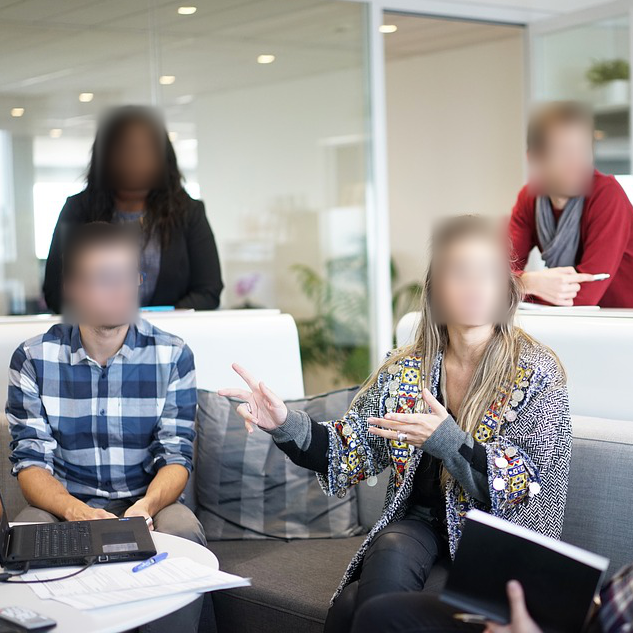

In [34]:
Image(imgFinal.entriesIterator.toArray).withFormat(Image.PNG).withWidth(500).display 